In [1]:
import raw_data
import ta

import math
import time

from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
daily_adjusted_df = raw_data.get_time_series_daily_adjusted("amzn")
prediction_period = 1  # Predict 1 day into the future
saved_models_root = "saved_models/"

display.display(daily_adjusted_df.describe())
display.display(daily_adjusted_df.head(5))

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,5361.000000,5361.000000,5361.000000,5361.000000,5361.000000,5.361000e+03,5361.0,5361.000000
mean,239.727108,242.617142,236.626308,239.782513,232.272085,6.498490e+06,0.0,1.000746
std,347.171219,349.844764,343.938938,347.153621,350.542372,5.438907e+06,0.0,0.033449
min,5.910000,6.100000,5.510000,5.970000,1.395800,4.060000e+04,0.0,1.000000
25%,40.350000,41.250000,39.700000,40.380000,36.070000,3.475069e+06,0.0,1.000000
50%,86.380000,88.500000,84.370000,86.360000,74.870000,5.431700e+06,0.0,1.000000
75%,271.430000,275.460000,269.230000,272.870000,269.900000,7.950300e+06,0.0,1.000000
max,2007.000000,2025.570000,2004.740000,2012.710000,2012.710000,1.043292e+08,0.0,3.000000


,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2018-08-31,2007.00,2022.38,2004.74,2012.71,2012.71,4147979,0.0,1.0
1,2018-08-30,1997.42,2025.57,1986.90,2002.38,2002.38,7277257,0.0,1.0
2,2018-08-29,1953.45,1998.69,1948.94,1998.10,1998.10,6531761,0.0,1.0
3,2018-08-28,1937.73,1941.78,1928.82,1932.82,1932.82,3100727,0.0,1.0
4,2018-08-27,1915.00,1927.70,1909.28,1927.68,1927.68,3569037,0.0,1.0


In [3]:
def preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period, selected_features=None):
    base_features = daily_adjusted_df[[
        "open",
        "high",
        "low",
        "adjusted_close",
        "volume"
    ]]

    # Truncate the most recent prediction_period days, since we don't have their target values
    processed_df = base_features.iloc[prediction_period:].copy()
    
    # Add technical indicators
    ta.add_all_ta_features(processed_df, "open", "high", "low", "adjusted_close", "volume", fillna=True)
    
    if selected_features is None:
        # Drop features with very low variance
        original_num_features = processed_df.shape[1]
        processed_df = processed_df.loc[:, processed_df.std() > 0.01]
        print("Dropped {} features.".format(original_num_features - processed_df.shape[1]))
    else:
        processed_df = processed_df.loc[:, selected_features]
    
    # Add the target column
    if prediction_period == 0:
        processed_df["future_percent_change"] = 0
    else:
        start_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[prediction_period:].values
        end_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[:-prediction_period].values
        processed_df["future_percent_change"] = (end_adjusted_closes - start_adjusted_closes) / start_adjusted_closes * 100.0
        
    return processed_df

In [4]:
def preprocess_features(df, means=None, stds=None):
    processed_features = df.iloc[:, df.columns != "future_percent_change"].copy()

    # Normalize features
    calculated_stats = False
    if means is None:
        means = processed_features.mean()
        calculated_stats = True
    if stds is None:
        stds = processed_features.std()
        calculated_stats = True
    processed_features = (processed_features - means) / stds
    
    if calculated_stats:
        return processed_features, means, stds
    return processed_features

def preprocess_targets(df):
    processed_targets = df["future_percent_change"].copy()
    return processed_targets

In [5]:
df = preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period)
display.display(df.describe())
display.display(df.head(5))

Dropped 2 features.


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
count,5360.000000,5360.000000,5360.000000,5360.000000,5.360000e+03,5.360000e+03,5.360000e+03,5.360000e+03,5360.000000,5.360000e+03,...,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,239.397393,242.285096,236.296436,231.939914,6.498928e+06,-1.318211e+07,-6.743988e+03,-5.733361e+03,-2.337032,1.846558e+06,...,-7.978274,44.907527,17.601764,17.634029,-82.398236,-4.935399,-0.058788,-0.129291,-88.416788,0.200927
std,346.363151,349.031539,343.121842,349.730257,5.439320e+06,5.362315e+07,8.457943e+06,2.409500e+06,7.966917,6.382674e+07,...,15.979914,16.564067,103.660965,102.460465,103.660965,21.752607,3.742698,3.764387,17.465729,3.820856
min,5.910000,6.100000,5.510000,1.395800,4.060000e+04,-5.795261e+08,-1.043292e+08,-1.272262e+07,-48.756969,-1.015144e+09,...,-100.000000,-4.237057,-923.811429,-847.172143,-1023.811429,-141.560941,-25.634726,-29.618110,-99.930293,-24.766064
25%,40.350000,41.245000,39.687500,36.067500,3.474983e+06,-4.965671e+06,-5.347200e+06,-1.196612e+06,-0.093051,-2.183447e+06,...,-19.731643,44.886072,12.914503,15.413285,-87.085497,-8.182135,-1.539341,-1.551312,-98.198768,-1.368653
50%,86.340000,88.490000,84.310000,74.850000,5.432310e+06,-1.346284e+05,-2.119500e+05,-4.825000e+03,0.028115,1.423119e+04,...,-8.387499,49.676457,36.885510,37.610462,-63.114490,-1.545206,-0.034677,-0.034683,-96.261948,0.035807
75%,271.325000,275.445000,269.215000,269.862500,7.951100e+06,3.433835e+06,5.438725e+06,1.149090e+06,0.147240,2.556332e+06,...,2.972775,53.535146,69.503568,68.328652,-30.496432,2.420270,1.387645,1.378105,-86.522913,1.563407
max,1997.420000,2025.570000,1986.900000,2002.380000,1.043292e+08,1.155101e+08,7.937440e+07,1.295436e+07,0.650570,1.714613e+09,...,37.739859,72.828932,100.000000,97.298196,-0.000000,176.806029,32.918740,28.456778,0.000000,34.471366


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
1,1997.42,2025.57,1986.90,2002.38,7277257,0.000000e+00,0,0.0,0.0,0.000000e+00,...,0.0,50.0,50.0,50.0,-50.0,0.0,0.000000,0.000000,0.000000,0.515886
2,1953.45,1998.69,1948.94,1998.10,6531761,4.925902e+06,-6531761,0.0,0.0,0.000000e+00,...,-100.0,50.0,50.0,50.0,-50.0,0.0,-0.213746,-0.213974,-0.213746,0.214203
3,1937.73,1941.78,1928.82,1932.82,3100727,5.190139e+06,-3100727,0.0,0.0,2.905194e+08,...,-100.0,50.0,50.0,50.0,-50.0,0.0,-3.267104,-3.321665,-3.473866,3.377448
4,1915.00,1927.70,1909.28,1927.68,3569037,2.374589e+06,-3569037,0.0,0.0,2.086350e+08,...,-100.0,50.0,50.0,50.0,-50.0,0.0,-0.265933,-0.266287,-3.730561,0.266642
5,1910.51,1916.01,1902.54,1905.39,2800863,1.945644e+06,-2800863,0.0,0.0,8.225270e+06,...,-100.0,50.0,50.0,50.0,-50.0,0.0,-1.156312,-1.163050,-4.843736,1.169839


In [6]:
# Use 85% for training, 10% for validation, and most recent 5% for testing
num_rows = len(df)
num_training = int(num_rows * 0.85)
num_validation = int(num_rows * 0.1)
num_testing = num_rows - num_training - num_validation

# Shuffle before splitting into training and validation sets
training_and_validation_df = df.tail(num_training + num_validation).sample(frac=1)

training_df = training_and_validation_df.head(num_training)
training_examples, feature_means, feature_stds = preprocess_features(training_df)
training_targets = preprocess_targets(training_df)

validation_df = training_and_validation_df.tail(num_validation)
validation_examples = preprocess_features(validation_df, feature_means, feature_stds)
validation_targets = preprocess_targets(validation_df)

testing_df = df.head(num_testing)
testing_examples = preprocess_features(testing_df, feature_means, feature_stds)
testing_targets = preprocess_targets(testing_df)

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Testing examples summary:")
display.display(testing_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Testing targets summary:")
display.display(testing_targets.describe())

Training examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,4.556000e+03,4.556000e+03,4.556000e+03,4.556000e+03,4.556000e+03,4.556000e+03,4.556000e+03,4.556000e+03,4.556000e+03,4.556000e+03,...,4.556000e+03,4.556000e+03,4.556000e+03,4.556000e+03,4.556000e+03,4.556000e+03,4.556000e+03,4.556000e+03,4.556000e+03,4.556000e+03
mean,-1.806379e-15,9.989083e-16,-4.521210e-15,-1.016843e-15,-3.742982e-17,-2.623986e-16,1.247661e-17,2.495321e-17,-3.111354e-16,3.275109e-17,...,-5.631628e-15,-1.455084e-15,1.235964e-15,-3.009981e-16,5.910792e-16,2.902371e-15,1.762321e-16,7.018091e-18,-6.550218e-17,-4.140674e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.914256e-01,-7.961844e-01,-7.884448e-01,-7.637641e-01,-1.167426e+00,-1.011400e+01,-1.202309e+01,-5.015608e+00,-5.716815e+00,-1.450596e+01,...,-3.006241e+00,-2.738365e+00,-2.897134e+00,-8.914667e+00,-8.339744e+00,-8.914667e+00,-5.444760e+00,-6.645180e+00,-7.625791e+00,-7.637641e-01
25%,-6.398685e-01,-6.430226e-01,-6.365451e-01,-6.123126e-01,-5.416242e-01,1.608994e-01,-6.326320e-01,-4.931172e-01,2.879369e-01,-6.621605e-02,...,-6.948475e-01,-7.941340e-01,4.820514e-03,-3.921701e-02,-1.651079e-02,-3.921701e-02,-2.705964e-01,-3.967776e-01,-3.789476e-01,-6.123126e-01
50%,-4.464245e-01,-4.465635e-01,-4.469304e-01,-4.583538e-01,-1.895937e-01,2.521419e-01,-9.693630e-03,-6.897171e-03,3.036147e-01,-2.670954e-02,...,4.180067e-02,-5.825012e-02,2.940727e-01,1.991162e-01,2.044133e-01,1.991162e-01,8.146827e-02,9.492894e-03,2.871196e-02,-4.583538e-01
75%,2.485415e-01,2.511360e-01,2.454015e-01,2.664696e-01,2.502949e-01,3.163942e-01,6.356124e-01,4.862220e-01,3.183657e-01,1.829126e-02,...,7.029961e-01,7.049397e-01,5.271351e-01,5.040698e-01,5.031596e-01,5.040698e-01,3.223085e-01,3.887413e-01,4.035400e-01,2.664696e-01
max,4.030293e+00,4.054603e+00,3.955362e+00,3.929473e+00,1.731952e+01,2.322175e+00,9.130183e+00,5.269385e+00,3.805048e-01,2.439652e+01,...,2.969376e+00,3.031212e+00,1.664331e+00,7.845700e-01,7.716415e-01,7.845700e-01,1.087292e+01,8.555067e+00,7.383080e+00,3.929473e+00


Validation examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,...,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,-0.075616,-0.076105,-0.075541,-0.069196,-0.022112,0.060886,-0.049313,-0.039862,-0.037587,0.080560,...,-0.042002,0.088542,-0.045622,-0.048508,-0.057645,-0.048508,-0.015849,-0.029678,-0.027023,-0.069196
std,0.901532,0.901560,0.902162,0.901781,0.801448,0.817281,0.910401,0.997757,1.058361,1.507703,...,0.970652,1.001642,1.008058,1.048794,1.108219,1.048794,0.955930,0.922919,0.936199,0.901781
min,-0.787436,-0.792042,-0.783690,-0.763857,-1.164094,-5.175921,-3.775282,-5.214286,-5.352713,-7.618262,...,-3.072787,-2.720541,-2.828861,-6.296984,-7.259491,-6.296984,-5.356652,-6.008539,-6.787256,-0.763857
25%,-0.638441,-0.642978,-0.636168,-0.611252,-0.543330,0.168396,-0.686922,-0.501487,0.286079,-0.063618,...,-0.647529,-0.740794,-0.028555,-0.055457,-0.032742,-0.055457,-0.196149,-0.456353,-0.439272,-0.611252
50%,-0.474009,-0.470610,-0.473445,-0.483619,-0.151331,0.248445,-0.174518,-0.030252,0.302207,-0.027008,...,-0.002962,0.045459,0.258578,0.149919,0.179549,0.149919,0.084575,-0.030308,-0.010942,-0.483619
75%,0.169187,0.160353,0.163834,0.192333,0.326161,0.323993,0.628660,0.438813,0.316362,0.020191,...,0.665223,0.817489,0.497330,0.492663,0.480580,0.492663,0.293943,0.361441,0.376737,0.192333
max,3.828338,3.821703,3.860732,3.813725,7.425708,1.839247,5.576895,4.023674,0.366871,22.758944,...,2.205862,2.997606,1.408500,0.774828,0.750922,0.774828,5.627101,3.797504,3.548853,3.813725


Testing examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,...,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000
mean,5.491736,5.499839,5.483022,5.443617,-0.407302,0.268334,-0.110779,-0.362281,0.311350,0.009843,...,-0.719457,-1.729115,0.325012,0.176167,0.177581,0.176167,-2.706865,-0.056011,-0.039995,5.443617
std,1.393432,1.398446,1.390201,1.373611,0.395039,0.082353,0.549845,0.495349,0.014135,2.958050,...,0.818419,1.316457,0.298314,0.239713,0.225908,0.239713,2.997363,0.419493,0.421923,1.373611
min,3.443014,3.448125,3.445868,3.419699,-0.899150,-0.013879,-1.893591,-2.170945,0.287150,-19.593294,...,-3.014586,-6.335039,-0.847792,-0.160275,-0.129620,-0.160275,-8.413671,-3.020916,-3.179320,3.419699
25%,4.286489,4.278373,4.316340,4.267477,-0.661970,0.227285,-0.466236,-0.655956,0.300219,-0.237263,...,-1.216114,-1.970580,0.195959,-0.030998,-0.016735,-0.030998,-4.823410,-0.278343,-0.259443,4.267477
50%,5.690202,5.716248,5.600031,5.618177,-0.521355,0.269871,-0.312988,-0.353684,0.307390,-0.026639,...,-0.727722,-1.589859,0.313107,0.130355,0.129112,0.130355,-2.751685,-0.071950,-0.052496,5.618177
75%,6.509718,6.484173,6.506252,6.420446,-0.276140,0.315468,0.358949,-0.019759,0.320791,0.140684,...,-0.248316,-1.230812,0.522751,0.321429,0.317114,0.321429,-0.065617,0.130718,0.149117,6.420446
max,8.236537,8.297697,8.269494,8.168274,1.725562,0.520189,1.493373,1.074810,0.351981,33.021029,...,1.721511,0.464918,1.114007,0.779018,0.737190,0.779018,5.876587,1.435200,1.410465,8.168274


Training targets summary:


count    4556.000000
mean        0.186587
std         3.922626
min       -24.766064
25%        -1.439882
50%         0.000000
75%         1.589892
max        34.471366
Name: future_percent_change, dtype: float64

Validation targets summary:


count    536.000000
mean       0.282519
std        3.722221
min      -12.733831
25%       -1.337606
50%        0.153554
75%        1.827301
max       30.178326
Name: future_percent_change, dtype: float64

Testing targets summary:


count    268.000000
mean       0.281526
std        1.652743
min       -5.206102
25%       -0.464807
50%        0.331902
75%        1.121217
max       13.216375
Name: future_percent_change, dtype: float64

In [7]:
print("Data for the most recent 5 days:")
display.display(testing_examples.head(5))
display.display(testing_targets.head(5))

Data for the most recent 5 days:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
1,8.236537,8.297697,8.269494,8.168274,0.115396,0.255371,-0.009694,-0.019759,0.300219,-0.027043,...,-0.025441,0.464918,0.313107,0.310887,0.315352,0.310887,0.162057,0.009493,0.028712,8.168274
2,8.037211,8.176653,8.095959,8.149168,-0.016756,0.343509,-0.761819,-0.019759,0.300219,-0.027043,...,-0.025441,-6.335039,0.313107,0.310887,0.315352,0.310887,0.162057,-0.045995,-0.026588,8.149168
3,7.965948,7.920382,8.003981,7.857767,-0.624966,0.348237,-0.366739,-0.019759,0.300219,5.572532,...,-0.025441,-6.335039,0.313107,0.310887,0.315352,0.310887,0.162057,-0.838634,-0.829739,7.857767
4,7.862908,7.856978,7.914653,7.834823,-0.541950,0.297859,-0.420664,-0.019759,0.300219,3.994263,...,-0.025441,-6.335039,0.313107,0.310887,0.315352,0.310887,0.162057,-0.059542,-0.040107,7.834823
5,7.842554,7.804337,7.883841,7.735323,-0.678122,0.290184,-0.332210,-0.019759,0.300219,0.131494,...,-0.025441,-6.335039,0.313107,0.310887,0.315352,0.310887,0.162057,-0.290681,-0.271867,7.735323


1    0.515886
2    0.214203
3    3.377448
4    0.266642
5    1.169839
Name: future_percent_change, dtype: float64

In [8]:
def construct_feature_columns(input_features):
    return [tf.feature_column.numeric_column(feature) for feature in input_features]

In [9]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(val) for key, val in dict(features).items()}

    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [10]:
def train_nn_regression_model(
    optimizer,
    steps,
    batch_size,
    batch_norm,
    dropout,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    save_model=True):
    periods = 10
    steps_per_period = steps / periods
    
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    if save_model:
        dir_name = "{}-{}".format(optimizer.get_name(), time.strftime("%Y%m%d-%H%M%S"))
        model_dir = "{}{}".format(saved_models_root, dir_name)
    else:
        model_dir = None
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        batch_norm=batch_norm,
        dropout=dropout,
        hidden_units=hidden_units,
        optimizer=optimizer,
        model_dir=model_dir)
    
    training_input_fn = lambda: input_fn(training_examples, training_targets, batch_size=batch_size)
    predict_training_input_fn = lambda: input_fn(training_examples, training_targets, num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: input_fn(validation_examples, validation_targets, num_epochs=1, shuffle=False)
    
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.3f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.3f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.3f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 0.324
  period 01 : 0.165
  period 02 : 0.125
  period 03 : 0.102
  period 04 : 0.087
  period 05 : 0.079
  period 06 : 0.070
  period 07 : 0.065
  period 08 : 0.062
  period 09 : 0.057
Model training finished.
Final RMSE (on training data):   0.057
Final RMSE (on validation data): 0.114


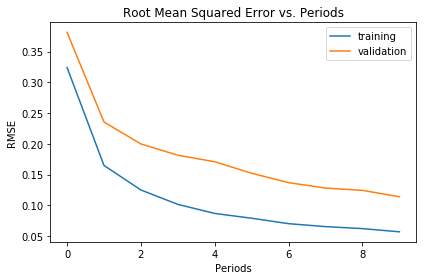

In [11]:
adam_regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdamOptimizer(learning_rate=0.00028),
    steps=10000,
    batch_size=128,
    batch_norm=False,
    dropout=None,
    hidden_units=[30, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [ ]:
adagrad_regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.007),
    steps=10000,
    batch_size=30,
    batch_norm=False,
    dropout=None,
    hidden_units=[30, 30, 20, 20, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [12]:
# Select regressor to use
regressor = adam_regressor

In [13]:
# Compute testing loss
predict_testing_input_fn = lambda: input_fn(testing_examples, testing_targets, num_epochs=1, shuffle=False)
testing_predictions = regressor.predict(input_fn=predict_testing_input_fn)
testing_predictions = np.array([item["predictions"][0] for item in testing_predictions])
testing_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(testing_predictions, testing_targets))
print("RMSE on testing data: %0.3f" % testing_root_mean_squared_error)

RMSE on testing data: 0.124


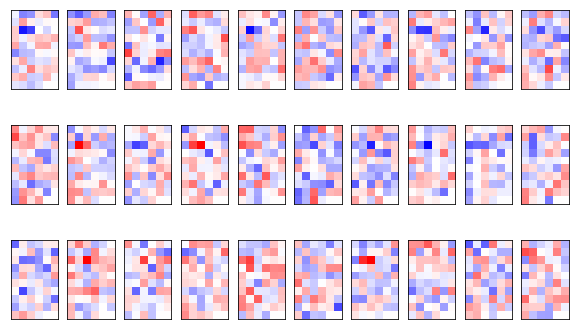

In [25]:
# Visualize weights from first layer
weights0 = regressor.get_variable_value("dnn/hiddenlayer_0/kernel")
num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(10, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Pad with 0s at end to make length 60
    padded = np.pad(coef, (0, 60 - coef.size), "constant", constant_values=0)
    cax = ax.matshow(np.expand_dims(padded, 0).reshape(10, 6), cmap=plt.cm.bwr, vmin=-0.5, vmax=0.5)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

In [26]:
selected_features = training_examples.columns.values
latest_df = preprocess_daily_adjusted_df(daily_adjusted_df.head(prediction_period + 365), 0, selected_features)
latest_features = preprocess_features(latest_df, feature_means, feature_stds).head(prediction_period)
latest_targets = preprocess_targets(latest_df).head(prediction_period)

predict_latest_input_fn = lambda: input_fn(latest_features, latest_targets, num_epochs=1, shuffle=False)
predictions = regressor.predict(input_fn=predict_latest_input_fn)
predictions = pd.Series([item["predictions"][0] for item in predictions])
display.display(predictions)

predictions_df = pd.DataFrame()
predictions_df["days_into_future"] = -predictions.index + prediction_period
predictions_df["close"] = latest_df["adjusted_close"].head(prediction_period) * (predictions/100.0 + 1.0)

print("Current predictions:")
display.display(predictions_df)

0   -0.044333
dtype: float64

Current predictions:


,days_into_future,close
0,1,2011.817699
